# Data Wrangling

After gathering recipe text data using scrapy, the next step is to clean and transform the data for later use.

## Exploring the Data

A preliminary data analysis is useful in determining how the data needs to be modified. The raw data
is gathered into several JSONLines files.

In [2]:
import pandas as pd
import json
import numpy as np
import joblib
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from typing import List, Iterable

# load data from jsonlines into pandas
with open("../datasets/raw/allrecipes.jl", "r", encoding="utf-8") as f:
    lines = f.read().splitlines()

line_dicts = [json.loads(line) for line in lines]
recipes = pd.DataFrame(line_dicts)
recipe_names = recipes["recipe_name"].values


In [10]:
# visualize word counts with histogram
def visualize_top_ngrams(words: Iterable[str],top_k: int, n: int):
    cutoff = 10  # discard n-grams with less than x occurrences
    # stop_words = ["39"]
    vectorizer = CountVectorizer(
    strip_accents="unicode", ngram_range=(n,n), min_df=cutoff, stop_words=None
)
    ngrams = vectorizer.fit_transform(words)
    ngram_df = (
        pd.DataFrame(
            data=ngrams.toarray(), columns=vectorizer.get_feature_names_out()
        )
        .sum(axis=0)
        .sort_values(ascending=True)
    )
    ngram_df.tail(top_k).plot(kind="barh") 
    plt.title(f'Counts of top {top_k} n-grams, $n={n}$')
    plt.xlabel('Counts')
    plt.show()
    return

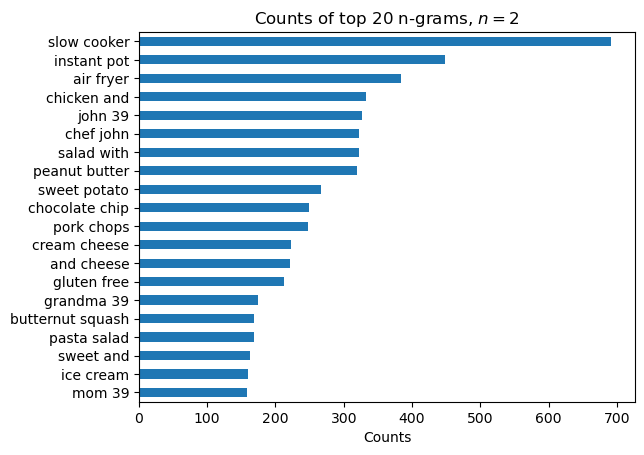

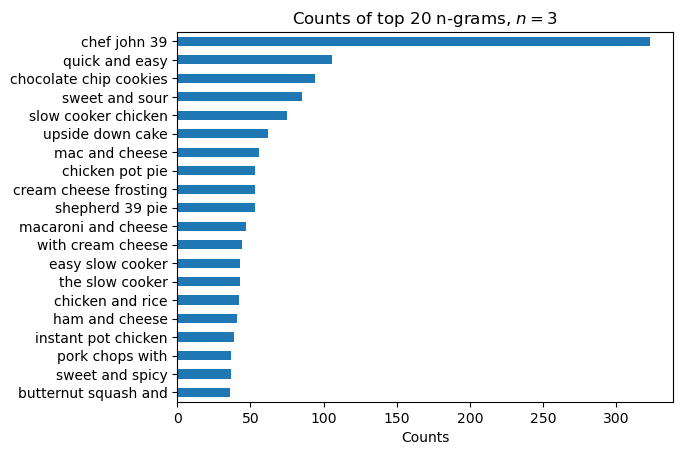

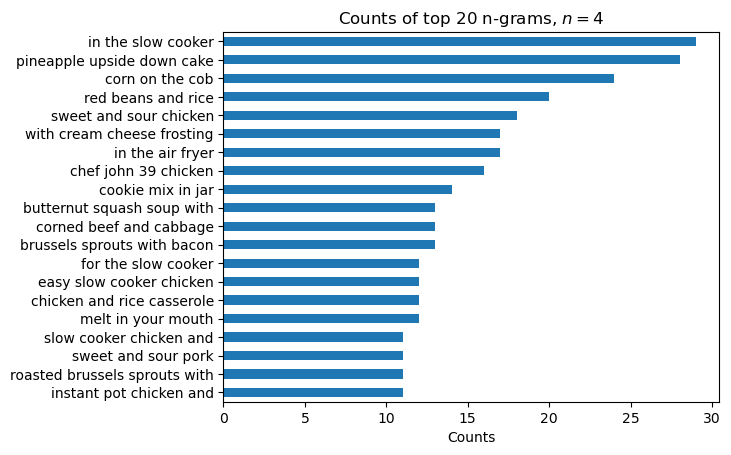

In [11]:
visualize_top_ngrams(recipe_names,20,2)
visualize_top_ngrams(recipe_names,20,3)
visualize_top_ngrams(recipe_names,20,4)

Plotting the top n-grams for $n=2,3,4$ shows that the number 39 appears frequently in the recipe names. 
Further inspection of the raw text data reveals that this is the result of escaped unicode characters,
so they will need to be substituted for their actual representations. <br>

We will need every part of the recipe (name, ingredients, instructions) to be described in elements of the vector database,
which means that recipes with any missing entries will be dropped. The text data for the recipe instructions and ingredients were parsed as an array when imported from JSONLines, but the vector database works best with strings. This means the texts for these categories will need to be concatenated together. The ingredient measurements will need to be rounded and the recipe instructions will be labeled with numbered steps. Finally, the all text data for a single recipe will be copied and merged into a single string to simplify the database schema. <br>

With these considerations in mind, cleaning and transforming the data will take these steps: <br>
1. Replace escaped unicode characters
2. Drop missing entries
3. Concatenate ingredient and instruction text
4. Fix number formatting for ingredient measurements
5. Add numbering to instructions
4. Combine text into single string

The code in *src/data/process_recipes.py* performs the tasks described, and the data are saved under *datasets/interim*, again in JSONLines format.

Afterwards, a deep learning model will be used to generate the vector embeddings and each embedding/recipe pair
will be stored in Chroma, a vector database. The code in *src/features/embeddings.py* performs this task.

## Visualizing Vector Embeddings

The vector database stores a latent representation of the recipe texts, which have been generated
using a transformer-based model. These vectors are high dimensionality (on the order of $10^3$)
and are impossible to interpret normally. However, dimensionality reduction techniques can be used to plot
representations of the vectors and provide a visual interpretation of the text embeddings.

In [12]:
import chromadb
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# t-SNE

# load numpy vector embeddings from chroma
chroma_handle = chromadb.PersistentClient(path='../datasets/processed/chroma_db_sample')
print(chroma_handle.list_collections())

[Collection(name=names), Collection(name=summed), Collection(name=instructions), Collection(name=ingredients)]


In [13]:
recipe_names = chroma_handle.get_collection(name='names')
stored_names = recipe_names.get(include=['embeddings', 'documents'])
embeddings = np.asarray(stored_names['embeddings'])

# Get subset of recipe names for easier visualization (35k is too many)
viz_names = pd.Series(stored_names['documents']).sample(n=50, random_state=3)
embeddings = embeddings[viz_names.index,:]

In [14]:
viz_names.head()

93         Breakfast Casserole with Hash Browns
67               Bread Machine Irish Soda Bread
6              Apple Raisin French Toast Strata
64                Irresistible Irish Soda Bread
96    Overnight Slow Cooker Breakfast Casserole
dtype: object

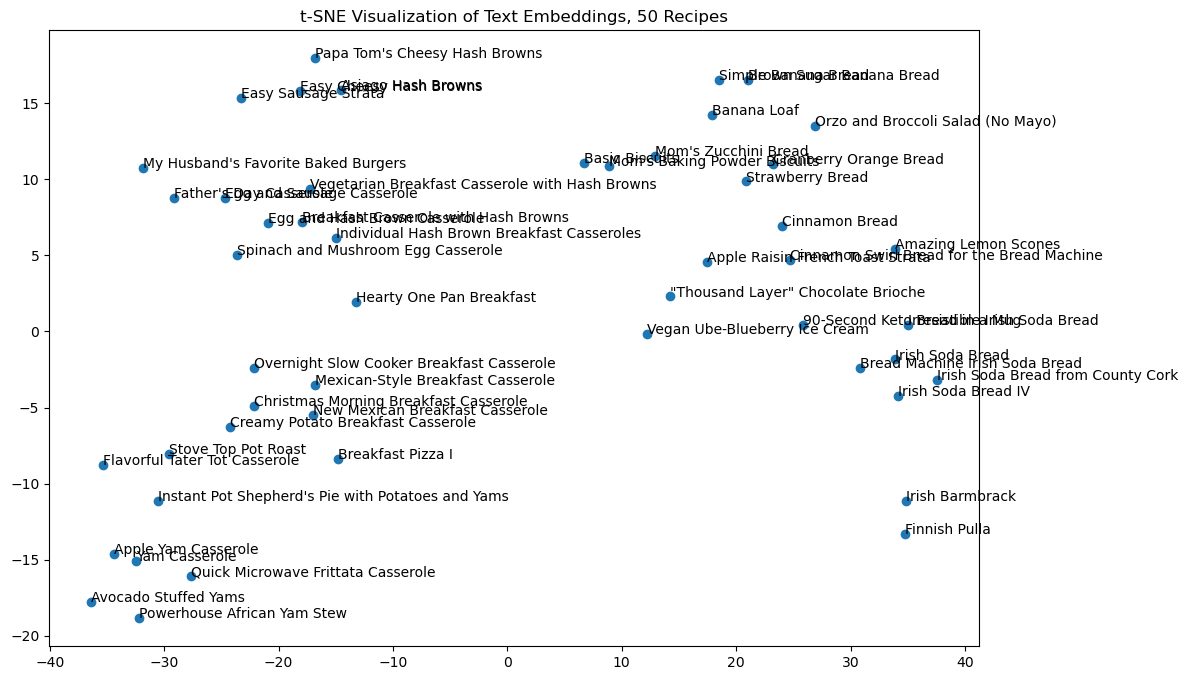

In [16]:
pca = PCA(n_components=50)
tsne = TSNE(n_components=2, n_jobs=-1, perplexity=5, n_iter=1000)
reduc_embeddings = pca.fit_transform(embeddings)
tsne_embeddings = tsne.fit_transform(reduc_embeddings).T

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(tsne_embeddings[0], tsne_embeddings[1])
ax.set_title('t-SNE Visualization of Text Embeddings, 50 Recipes')
for i, name in enumerate(viz_names.values):
    ax.annotate(name, (tsne_embeddings[0,i], tsne_embeddings[1,i]))

Note how similar recipes are grouped together; this indicates that the vector embeddings were able to capture
the semantic meaning in the recipe text.